# EE837B Advances in Convolutional Neural Networks (Fall 2023)
## Programming Assignment
Department of Electrical Engineering, KAIST

- Course Instructor : Prof. Junmo Kim

- Primary TA : Hyounguk Shon

- For questions regarding this assignment, use the course Q&A board on KLMS.

---

In this programming assignment, you are asked to reproduce the [Knowledge Distillation (KD) algorithm](https://arxiv.org/abs/1503.02531) in PyTorch. Your python code should distill a pre-trained teacher model into a smaller student model using the CIFAR-100 dataset. Additionally, we have an optional challenge for bonus credits. 

In [1]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import random

import gdown
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

# set random seed for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# Define ResNet architecture
Do not change this code block

In [3]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False
    )

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, is_last=False):
        super(BasicBlock, self).__init__()
        self.is_last = is_last
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out

class ResNet(nn.Module):
    def __init__(self, depth, num_filters, block_name="BasicBlock", num_classes=100):
        super(ResNet, self).__init__()
        assert (
            depth - 2
        ) % 6 == 0, "When use basicblock, depth should be 6n+2, e.g. 20, 32, 44, 56, 110, 1202"
        n = (depth - 2) // 6
        block = BasicBlock

        self.inplanes = num_filters[0]
        self.conv1 = nn.Conv2d(3, num_filters[0], kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_filters[0])
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, num_filters[1], n)
        self.layer2 = self._make_layer(block, num_filters[2], n, stride=2)
        self.layer3 = self._make_layer(block, num_filters[3], n, stride=2)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(num_filters[3] * block.expansion, num_classes)
        self.stage_channels = num_filters

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.inplanes,
                    planes * block.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = list([])
        layers.append(
            block(self.inplanes, planes, stride, downsample, is_last=(blocks == 1))
        )
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, is_last=(i == blocks - 1)))

        return nn.Sequential(*layers)

    def get_feat_modules(self):
        feat_m = nn.ModuleList([])
        feat_m.append(self.conv1)
        feat_m.append(self.bn1)
        feat_m.append(self.relu)
        feat_m.append(self.layer1)
        feat_m.append(self.layer2)
        feat_m.append(self.layer3)
        return feat_m

    def get_bn_before_relu(self):
        bn1 = self.layer1[-1].bn2
        bn2 = self.layer2[-1].bn2
        bn3 = self.layer3[-1].bn2
        return [bn1, bn2, bn3]

    def get_stage_channels(self):
        return self.stage_channels

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)  # 32x32
        f0 = x

        x, f1_pre = self.layer1(x)  # 32x32
        f1 = x
        x, f2_pre = self.layer2(x)  # 16x16
        f2 = x
        x, f3_pre = self.layer3(x)  # 8x8
        f3 = x

        x = self.avgpool(x)
        avg = x.reshape(x.size(0), -1)
        out = self.fc(avg)

        return out

def resnet8x4(**kwargs):
    return ResNet(8, [32, 64, 128, 256], "basicblock", **kwargs)

def resnet32x4(**kwargs):
    return ResNet(32, [32, 64, 128, 256], "basicblock", **kwargs)

# Define Base Trainer Class
Do not change this code block.

The base trainer will automatically download and load pre-trained teacher weights.

In [4]:
class BaseTrainer:
    #pretrained_teacher_link = 'https://drive.google.com/uc?id=1Gh3Z8BZ62PGD7PQiFiwmU9vMwMpF5F46'    
    pretrained_teacher_link = 'https://drive.google.com/uc?id=1li1w_V3-NxPDUC9uofxijDnTABkp9rhD'


    def __init__(self):
        self.teacher = resnet32x4(num_classes=100)
        self.student = resnet8x4(num_classes=100)
        gdown.download(self.pretrained_teacher_link, './resnet_32x4.pth', resume=True)
        self.teacher.load_state_dict(torch.load("./resnet_32x4.pth", map_location="cpu")["model"])

        self.train_transform = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
                ])
        self.test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
                ])

        self.train_set = datasets.CIFAR100('./data/', download=True, train=True, transform=self.train_transform)
        self.test_set = datasets.CIFAR100('./data/', download=False, train=False, transform=self.test_transform)
        self.test_dataloader = DataLoader(self.test_set, batch_size=64, shuffle=False)

    def save_student_checkpoint(self, ckpt_path):
        state_dict = self.student.state_dict()
        torch.save(state_dict, ckpt_path)

    def load_student_checkpoint(self, ckpt_path):
        state_dict = torch.load(ckpt_path, map_location="cpu")
        self.student.load_state_dict(state_dict)

    @torch.no_grad()
    def evaluate_student(self):
        self.student.cuda().eval()
        n = 0
        correct = 0
        for image, target in self.test_dataloader:
            image = image.cuda()
            target = target.cuda()
            output = self.student(image)
            n += image.size(0)
            correct += output.max(-1).indices.eq(target).sum().item()
        accuracy = 100 * correct / n
        return accuracy

    def train_student(self):
        pass

# Training algorithm implementation

In this section, you need to implement training of the student model.
Specifically, you need to implement the followings:

1. Knowledge Distillation algorithm
2. Training pipeline

You are free to edit below skeleton code. You are not allowed to edit the model architecture and data augmentation method.

In [5]:
# class KDLoss(nn.Module):
#     def __init__(self, T=4.0):
#         super(KDLoss, self).__init__()
#         self.temperature = T
#     def forward(self, student_logits, teacher_logits):
#         soft_student = nn.Softmax(dim=1)(student_logits / self.temperature)
#         soft_teacher = nn.Softmax(dim=1)(teacher_logits / self.temperature)
#         kd_loss_1 = nn.KLDivLoss(reduction="batchmean")(torch.log(soft_student), soft_teacher) * (self.temperature)**2
#         kd_loss_2 = nn.KLDivLoss(reduction="batchmean")(torch.log(soft_student.T), soft_teacher.T) * (self.temperature)**2
#         return kd_loss_1 + kd_loss_2
        
# class KDTrainer(BaseTrainer):
#     def __init__(self):
#         super().__init__()
#         ### YOU MAY EDIT BELOW ###
#         self.train_dataloader = DataLoader(self.train_set, batch_size=64, shuffle=True, num_workers=2, drop_last=True)

#         self.init_lr = 0.05
#         self.max_epoch = 240
#         self.optimizer = optim.SGD(self.student.parameters(), lr=self.init_lr, momentum=0.9, weight_decay=5e-4)
#         #...
#         self.temperature = 4.0  # in original paper, range from 1 - 20
#         self.alpha = 0.9
#         self.beta = 1.0
#         self.lr_scheduler = optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[150, 180, 210], gamma=0.1)
#         self.cl_loss = nn.CrossEntropyLoss()
#         self.kd_loss = KDLoss(T=self.temperature)
        
#     def train_student(self):
#         #### IMPLEMENT TRAINING HERE ####
#         self.teacher.cuda().eval()
#         self.student.cuda().train()
#         #print(self.student)
#         self.train_loss_arr = []
#         self.val_acc_arr = []
#         for epoch in range(self.max_epoch):
#             print(len(self.train_dataloader.dataset))
#             #...
#             running_loss = 0.0
#             for batch_idx, (data, hard_targets) in enumerate(self.train_dataloader):
#                 data, hard_targets = data.cuda(), hard_targets.cuda()
#                 with torch.no_grad():
#                   teacher_logits = self.teacher(data) 
                
#                 student_logits = self.student(data)
#                 loss = self.alpha * self.cl_loss(nn.Softmax(dim=1)(student_logits), hard_targets) + self.beta * self.kd_loss(student_logits, teacher_logits)
#                 self.optimizer.zero_grad()
#                 loss.backward()
#                 self.optimizer.step()
#                 running_loss += loss.item() # mean batch loss (1) + mean batch loss (2) + ....
                
#             train_loss = running_loss / len(self.train_dataloader) # divided by number of batch
#             val_acc = self.evaluate_student()
#             self.train_loss_arr.append(train_loss)
#             self.val_acc_arr.append(val_acc)
#             print("Epoch: %d, Loss: %f" % (epoch+1, train_loss)) 
#             print("val_acc: ", val_acc)
#             self.lr_scheduler.step()
        
#         # Save training history
#         np.savetxt('train_loss_arr.csv', self.train_loss_arr, delimiter=',')
#         np.savetxt('val_acc_arr.csv', self.val_acc_arr, delimiter=',')
#         # Learning curve visualization
#         self.train_loss_arr = np.loadtxt('train_loss_arr.csv', delimiter=',')
#         epoch_arr = np.arange(1, self.max_epoch+1)
#         plt.plot(epoch_arr, self.train_loss_arr)
# #         plt.plot(epoch_arr, self.val_acc_arr)
#         plt.xlabel("Epoch")
#         plt.ylabel("Training loss")
#         plt.grid(True)

# Training and Evaluation

You do not need to modify the code in this section except the checkpoint path (**CKPT_PATH**).

TAs will reproduce the results of your report with submitted checkpoint.

**Before submission, make sure to check that the following code can print evaluation on your student model.**

In [6]:
# CKPT_PATH = "./student_checkpoint.pth"

# trainer = KDTrainer()
# trainer.train_student()
# trainer.save_student_checkpoint(CKPT_PATH)

In [7]:
# trainer.load_student_checkpoint(CKPT_PATH)
# accuracy = trainer.evaluate_student()

# print(f"Student model test accuracy: {accuracy:.3f} %")
# print(f"Is above threshold performance? {accuracy > 72.2}")

In [8]:
def cosine_similarity(a, b, eps=1e-8):
    return (a * b).sum(1) / (a.norm(dim=1) * b.norm(dim=1) + eps)


def pearson_correlation(a, b, eps=1e-8):
    return cosine_similarity(a - a.mean(1).unsqueeze(1),
                             b - b.mean(1).unsqueeze(1), eps)


def inter_class_relation(y_s, y_t):
    return 1 - pearson_correlation(y_s, y_t).mean()


def intra_class_relation(y_s, y_t):
    return inter_class_relation(y_s.T, y_t.T)


class NewLoss(nn.Module):
    def __init__(self, beta=1.0, gamma=1.0, T=4.0):
        super(NewLoss, self).__init__()
        self._beta = beta
        self.gamma = gamma
        self.T = T

    def forward(self, student_logits, teacher_logits):
        y_s = (student_logits / self.T).softmax(dim=1)
        y_t = (teacher_logits / self.T).softmax(dim=1)

        inter_loss = self.T**2 * inter_class_relation(y_s, y_t)
        intra_loss = self.T**2 * intra_class_relation(y_s, y_t)
        kd_loss = self._beta * inter_loss + self.gamma * intra_loss
        return kd_loss

class ImprovedKDTrainer(BaseTrainer):
    def __init__(self):
        super().__init__()
        ### YOU MAY EDIT BELOW ###
        self.train_dataloader = DataLoader(self.train_set, batch_size=64, shuffle=True, num_workers=2, drop_last=True)

        self.init_lr = 0.05
        self.max_epoch = 240
        self.optimizer = optim.SGD(self.student.parameters(), lr=self.init_lr, momentum=0.9, weight_decay=5e-4)
        #...
        self.temperature = 4  # in original paper, range from 1 - 20
        self.alpha = 0.9
        self.beta = 1.0 - self.alpha # weighted average
        self.lr_scheduler = optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[150, 180, 210], gamma=0.1)
        #self.lr_scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.95, last_epoch=-1)
        self.criterion = nn.CrossEntropyLoss()
        self.use_kldiv = False
        # self.kd_loss = KDLoss(use_kldiv=self.use_kldiv, T=self.temperature).cuda()
        self.kd_loss = NewLoss(beta=2, gamma=2).cuda()


    def train_student(self):
        # print(self.student.get_feat_modules())
        #### IMPLEMENT TRAINING HERE ####
        self.teacher.cuda().eval()
        self.student.cuda().train()
        self.train_loss_arr = []
        self.val_acc_arr = []
        for epoch in range(self.max_epoch):
            print(len(self.train_dataloader.dataset))
            #...
            running_loss = 0.0
            for batch_idx, (data, hard_targets) in enumerate(self.train_dataloader):
                data, hard_targets = data.cuda(), hard_targets.cuda()
                with torch.no_grad():
                  soft_targets = self.teacher(data) # only logits returned, no feat returned
                  # print(soft_targets.shape)
                logits = self.student(data)
                loss = 0.1 * self.criterion(nn.Softmax(dim=1)(logits), hard_targets) + 0.9 * self.kd_loss(logits, soft_targets)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item() # mean batch loss (1) + mean batch loss (2) + ....

            train_loss = running_loss / len(self.train_dataloader) # divided by number of batch
#             if (epoch == 81 or epoch == 121):
                # val_acc = self.evaluate_student()
                # print("val_acc: ", val_acc)
            self.train_loss_arr.append(train_loss)
            # self.val_acc_arr.append(val_acc)
            print("Epoch: %d, Loss: %f" % (epoch+1, train_loss))
            self.lr_scheduler.step()

        # Save training history
        np.savetxt('train_loss_arr.csv', self.train_loss_arr, delimiter=',')
        # np.savetxt('val_acc_arr.csv', self.val_acc_arr, delimiter=',')
        # Learning curve visualization
        self.train_loss_arr = np.loadtxt('train_loss_arr.csv', delimiter=',')
        epoch_arr = np.arange(1, self.max_epoch+1)
        plt.plot(epoch_arr, self.train_loss_arr)
#         plt.plot(epoch_arr, self.val_acc_arr)
        plt.xlabel("Epoch")
        plt.ylabel("Training loss")
        plt.grid(True)

Downloading...
From: https://drive.google.com/uc?id=1li1w_V3-NxPDUC9uofxijDnTABkp9rhD
To: /kaggle/working/resnet_32x4.pth
100%|██████████| 59.6M/59.6M [00:00<00:00, 206MB/s]


100%|██████████| 169001437/169001437 [00:04<00:00, 34086108.86it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data/
50000
Epoch: 1, Loss: 42.357118
50000
Epoch: 2, Loss: 33.558041
50000
Epoch: 3, Loss: 28.729025
50000
Epoch: 4, Loss: 26.010185
50000
Epoch: 5, Loss: 24.212911
50000
Epoch: 6, Loss: 22.816385
50000
Epoch: 7, Loss: 21.805165
50000
Epoch: 8, Loss: 21.116349
50000
Epoch: 9, Loss: 20.499477
50000
Epoch: 10, Loss: 20.003345
50000
Epoch: 11, Loss: 19.651983
50000
Epoch: 12, Loss: 19.255201
50000
Epoch: 13, Loss: 18.986353
50000
Epoch: 14, Loss: 18.740957
50000
Epoch: 15, Loss: 18.639622
50000
Epoch: 16, Loss: 18.436668
50000
Epoch: 17, Loss: 18.266736
50000
Epoch: 18, Loss: 18.121607
50000
Epoch: 19, Loss: 18.028073
50000
Epoch: 20, Loss: 17.968925
50000
Epoch: 21, Loss: 17.839187
50000
Epoch: 22, Loss: 17.808104
50000
Epoch: 23, Loss: 17.623830
50000
Epoch: 24, Loss: 17.630339
50000
Epoch: 25, Loss: 17.505767
50000
Epoch: 26, Loss: 17.395718
50000
Epoch: 27, Loss: 17.423925
50000
Epoch: 28, Loss: 17.318122
50000
Epoch: 29, Loss: 17.249645

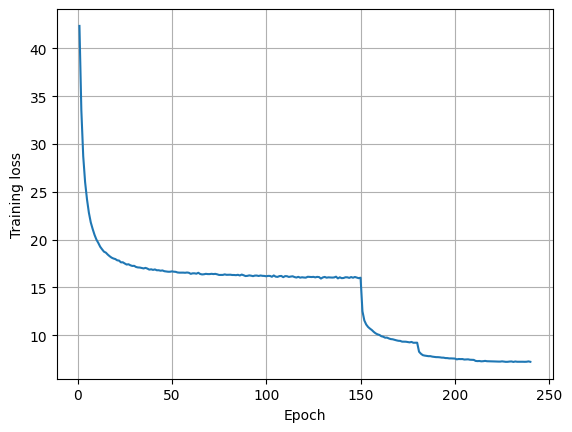

In [9]:
CKPT_PATH = "./student_improved_checkpoint.pth"

trainer = ImprovedKDTrainer()
trainer.train_student()
trainer.save_student_checkpoint(CKPT_PATH)

In [10]:
trainer.load_student_checkpoint(CKPT_PATH)
accuracy = trainer.evaluate_student()

print(f"Improved student model test accuracy: {accuracy:.3f} %")

Improved student model test accuracy: 76.100 %
